In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import random

In [2]:
SEED = 666
DATA_FILE = '../Datasets/cats/data/breeds_data_final.pkl'
IMAGES_DIR = '../Datasets/cats/images'
FIGURES_DIR = '../Figures/'
CHECKPOINTS_DIR = '../History'
RESOLUTION = 128 # 128
LABELS = 'coat' # 'breeds'

In [3]:
random.seed(SEED)
np.random.seed(SEED)

In [4]:
data = pd.read_pickle(DATA_FILE)
# (Solved) PROBLEM: 26 unique breeds, but 66 included in final number of breeds, 
# lots of inaccuracy to account for here
#len(data['breed'].unique())
data

,age,gender,size,coat,breed,image
3,1.0,0.0,3.0,2.0,0.0,Abyssinian/46620170_3.jpg
7,0.0,1.0,2.0,2.0,0.0,Abyssinian/46463847_8.jpg
11,2.0,1.0,2.0,2.0,0.0,Abyssinian/46305208_12.jpg
12,0.0,0.0,2.0,2.0,0.0,Abyssinian/46301725_13.jpg
13,3.0,1.0,3.0,2.0,0.0,Abyssinian/46293180_14.jpg
...,...,...,...,...,...,...
67140,1.0,1.0,2.0,2.0,65.0,Tuxedo/43781057_7295.jpg
67141,0.0,0.0,2.0,2.0,65.0,Tuxedo/43773439_7304.jpg
67142,3.0,0.0,1.0,2.0,65.0,Tuxedo/43773383_7305.jpg
67143,0.0,1.0,2.0,1.0,65.0,Tuxedo/43773168_7306.jpg


In [5]:
# Cats data string convertor
# Data was collected from Analysis/cats/cats_prediction_2.ipynb
age_list = ['Adult', 'Baby', 'Senior', 'Young']
gender_list = ['Female', 'Male']
size_list = ['Extra Large', 'Large', 'Medium', 'Small']
coat_list = ['Long', 'Medium', 'Short']
breed_list = ['Abyssinian', 'American Bobtail', 'American Curl',
        'American Shorthair', 'American Wirehair', 'Applehead Siamese',
        'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
        'Burmese', 'Burmilla', 'Calico', 'Canadian Hairless', 'Chartreux',
        'Chausie', 'Chinchilla', 'Cornish Rex', 'Cymric', 'Devon Rex',
        'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair',
        'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
        'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
        'Havana', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Korat',
        'LaPerm', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung',
        'Norwegian Forest Cat', 'Ocicat', 'Oriental Long Hair',
        'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob',
        'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold',
        'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Singapura',
        'Snowshoe', 'Somali', 'Sphynx - Hairless Cat', 'Tabby', 'Tiger',
        'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora',
        'Turkish Van', 'Tuxedo', 'York Chocolate']

#breed_list = np.empty(len(full_breed_list),dtype=object)
#for i in range(len(full_breed_list)):
#    if (i+1 in data['breed'].unique()):
#        breed_list[i] = full_breed_list[i]

#breed_list = breed_list[breed_list != None]
#print(breed_list)

def get_cat_string(cat, value):
    if(cat == 'age'):
        return age_list[int(value)]
    elif(cat == 'gender'):
        return gender_list[int(value)]
    elif(cat == 'size'):
        return size_list[int(value)]
    elif(cat == 'coat'):
        return coat_list[int(value)]
    elif(cat == 'breed'):
        return breed_list[int(value)]

# Prepare Data
- Label : coat

In [6]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Fix issues with truncated images

In [7]:
# Load images from paths stored in the dataframe
def load_images(df):
    images = []
    for path in df['image']:
        #print(os.path.join(IMAGES_DIR, path))
        img = load_img(os.path.join(IMAGES_DIR, path), target_size=(RESOLUTION, RESOLUTION))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        #img = cv2.imread(os.path.join(IMAGES_DIR, path), cv2.COLOR_RGB2BGR)
        #img = cv2.resize(img, (RESOLUTION, RESOLUTION))
        images.append(img.astype(np.float32) / 255.0)
        #images.append(img)
    return np.vstack(images)

In [8]:
images = load_images(data)

In [9]:
# Process data in analysis.ipynb
print(data.iloc[:, 4].shape)
print(images.shape)

(41939,)
(41939, 128, 128, 3)


29892 Baby Male Small Short
24708 Adult Female Small Long
28467 Adult Female Medium Long
18579 Adult Female Medium Short


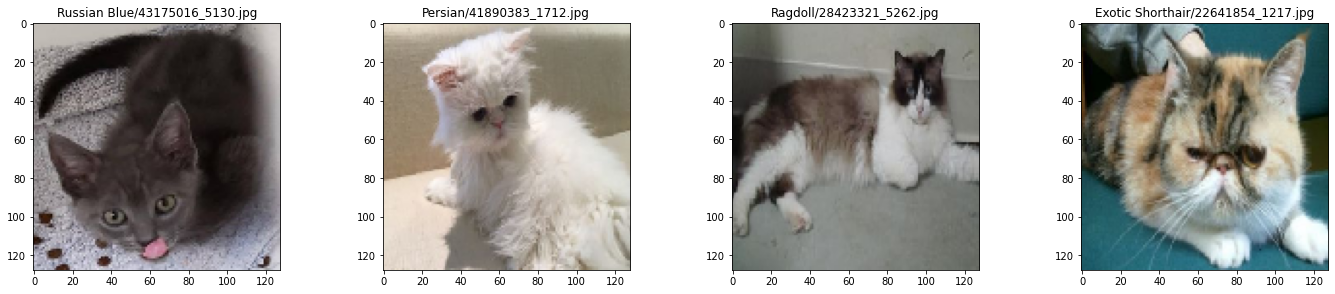

In [10]:
# I'm doubting if ML can determine a cat's gender... will test it using CNN
fig = plt.figure(figsize=(24, 10))
for i, r in enumerate([random.randint(0, images.shape[0]) for _ in range(4)]):
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(data.iloc[r, 5])
    ax.imshow(images[r])
    print(r, get_cat_string('age', data.iloc[r, 0]), get_cat_string('gender', data.iloc[r, 1]), get_cat_string('size', data.iloc[r, 2]), get_cat_string('coat', data.iloc[r, 3]))

In [11]:
# Import ml libraries
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [12]:
# Split datasets
# Train - 0.6 : Val - 0.2 : Test - 0.2
# Breeds - [:, 4] are labels, images are X

X_train, X_test, y_train, y_test = train_test_split(images, data[LABELS], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(len(y_train), len(y_train.unique()))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

25163 3
(25163, 128, 128, 3) (25163,) (8388, 128, 128, 3) (8388,) (8388, 128, 128, 3) (8388,)


In [13]:
# Chekpoints callback function
def make_checkpoints(name):
    return callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINTS_DIR, name + '.ckpt'), save_weights_only=True, verbose=1)

In [14]:
# Plot graphs functions
def plot_accuracy(history, path):
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Accuracy_Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.savefig(path)
    plt.show()
def plot_loss(history, path):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label = 'Loss_Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig(path)
    plt.show()

# Network 1 - Basic CNN

##  Test 1 - Deep CNN architecture (Demo)
- The network is overfitting. Validation accuracy cannot escape from the local minima
- Validation accuracy is between 60% and 70% after 50 epochs

In [15]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(len(coat_list), activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [16]:
# No need to train this
epochs = 1
#opt = optimizers.Adam(lr = 0.01)

model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
#history_1 = model_1.fit(X_train, to_categorical(y_train), epochs=epochs, validation_data=(X_val, to_categorical(y_val)))

In [17]:
#plot_accuracy(history_1)
#plot_loss(history_1)

In [18]:
#model.save('test_1')

## Test 2 - Deep CNN architecture with augumented images
- This is a machine killer

In [19]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESOLUTION, RESOLUTION, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(len(coat_list), activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Generate extra training images from Zoom, Flip, Rotation
dg = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True)
dg.fit(X_train)

In [22]:
epochs = 20
batch = 16
lr = 0.0005
mtm = 0.9 # for RMSprop opt
opt = optimizers.Adam(learning_rate=lr)
#opt = optimizers.RMSprop(learning_rate=lr, momentum=mtm)
n = 'test_'+LABELS+'_cnn_augmented'

model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history_2 = model_2.fit(dg.flow(X_train, to_categorical(y_train), batch_size=batch), 
                        steps_per_epoch = len(X_train) / batch, epochs=epochs, 
                        validation_data=(X_val, to_categorical(y_val)), 
                        callbacks=[make_checkpoints(n)])

Epoch 1/20
1572/1572 [==============================] - 70s 43ms/step - loss: 0.5367 - accuracy: 0.6296 - val_loss: 0.5173 - val_accuracy: 0.6317

Epoch 00001: saving model to ../History\test_coat_cnn_augmented.ckpt
Epoch 2/20
1572/1572 [==============================] - 65s 42ms/step - loss: 0.5173 - accuracy: 0.6403 - val_loss: 0.5118 - val_accuracy: 0.6423

Epoch 00002: saving model to ../History\test_coat_cnn_augmented.ckpt
Epoch 3/20
1572/1572 [==============================] - 66s 42ms/step - loss: 0.5224 - accuracy: 0.6339 - val_loss: 0.5071 - val_accuracy: 0.6462

Epoch 00003: saving model to ../History\test_coat_cnn_augmented.ckpt
Epoch 4/20
1572/1572 [==============================] - 66s 42ms/step - loss: 0.5122 - accuracy: 0.6426 - val_loss: 0.5019 - val_accuracy: 0.6522

Epoch 00004: saving model to ../History\test_coat_cnn_augmented.ckpt
Epoch 5/20
1572/1572 [==============================] - 66s 42ms/step - loss: 0.5098 - accuracy: 0.6429 - val_loss: 0.5001 - val_accurac

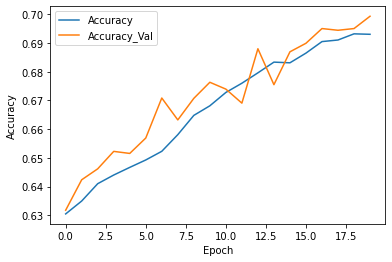

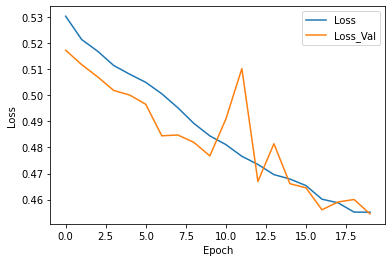

In [23]:
p = FIGURES_DIR+'basic_CNN_'+LABELS+'/'
name = 'test_'+LABELS
if not os.path.exists(p.rsplit('/',1)[0]):
    os.makedirs(p.rsplit('/',1)[0])

name_acc = p+name+'_epochs_'+str(epochs)+'_acc.png'
plot_accuracy(history_2,name_acc)
name_loss = p+name+'_epochs_'+str(epochs)+'_loss.png'
plot_loss(history_2,name_loss)
# Learning rate and Epochs may need changes. Currently 0.001 by default for Adam

# Exports

In [24]:
import pickle

with open('../History/test_'+LABELS+'_epochs_'+str(epochs), 'wb') as file_pi:
        pickle.dump(history_2.history, file_pi)

In [25]:
# Predict the values from the validation dataset
y_pred = model_2.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#print(to_categorical(train_y).shape)
y_true = np.argmax(to_categorical(y_test),axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

3
tf.Tensor(
[[ 832    7 1024]
 [ 272    7  959]
 [ 243    3 5041]], shape=(3, 3), dtype=int32)


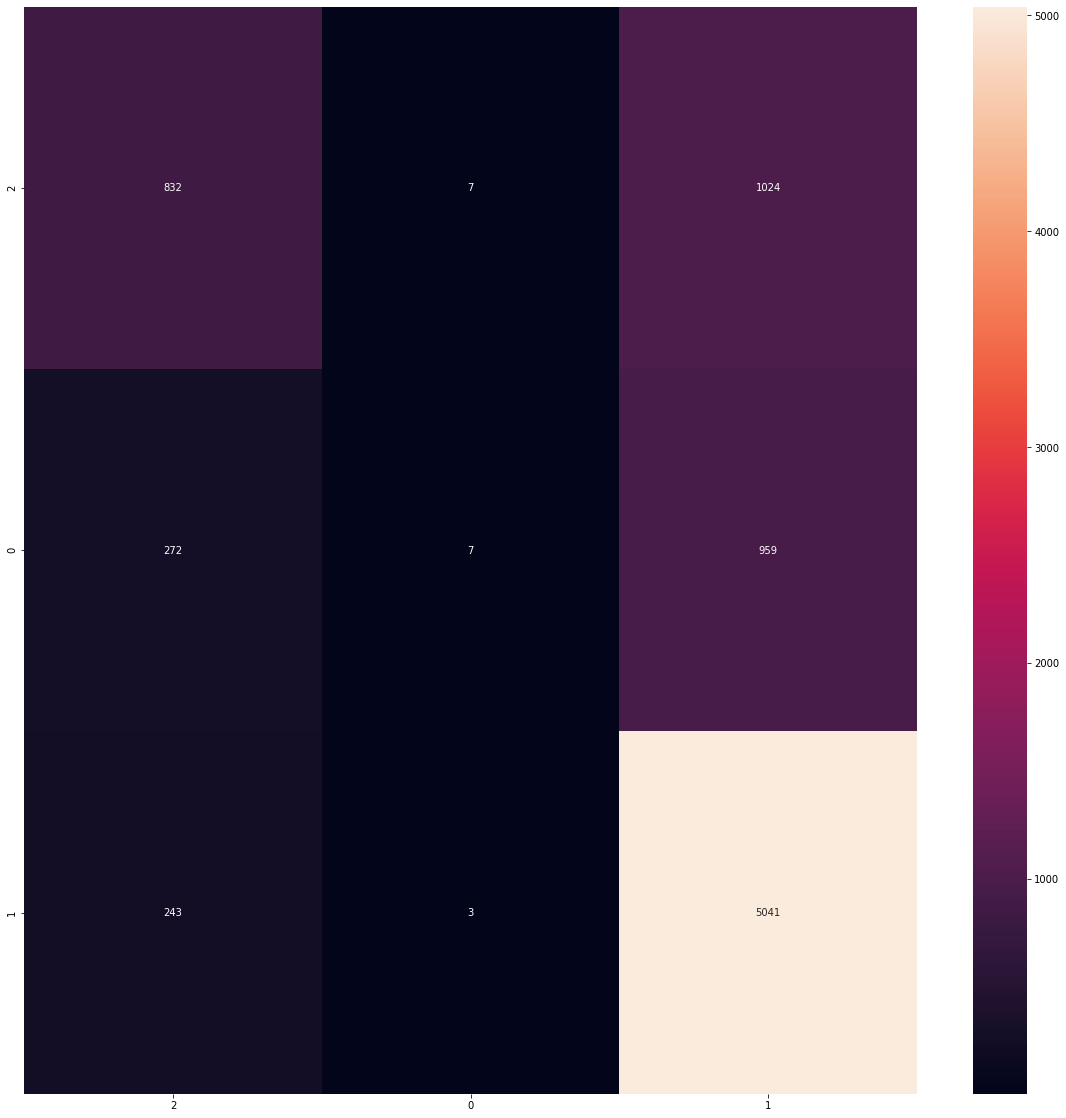

In [26]:
import seaborn as sns
print(len(pd.unique(y_pred_classes)))

print(confusion_mtx)

br = pd.unique(y_pred_classes)

plt.figure(figsize=(20, 20))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=br, yticklabels=br)
plt.savefig(p+'Basic_heatmap_epochs_'+str(epochs)+'.png')

In [27]:
# print single prediction
# print(y_pred[0])
# plt.imshow(val_x[0])

In [28]:
#p = FIGURES_DIR+'basic_CNN_'+LABEL+'/'
#name = 'test_'+LABEL
#if not os.path.exists(p.rsplit('/',1)[0]):
#    os.makedirs(p.rsplit('/',1)[0])

#plt.plot(history_2.history['accuracy'], label='training data')
#plt.plot(history_2.history['val_accuracy'], label='validation data')
#t = 'Accuracy with '+str(epochs)+' Epochs'
#plt.title(t)
#plt.ylabel('Accuracy')
#plt.xlabel('No. epoch')
#plt.legend(loc="upper left")
#name = p+name+'_epochs_'+str(epochs)+'.png'
#plt.savefig(name)
#plt.show()

# Network 2 - Combine Net